Extract feature from `Functional brain networks reflect spatial and temporal autocorrelation` (Shinn, NN, 2023) 

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../../")
from pathlib import Path
root = Path("../../")

PosixPath('../..')

In [3]:
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm, trange
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
import statsmodels.api as sm
from joblib import Parallel, delayed
%matplotlib inline

In [4]:
import importlib
import pyTVDN.utils
importlib.reload(pyTVDN.utils)
from pyTVDN.utils import load_pkl, save_pkl
from pyTVDN.psd import butter_bandpass_filter

In [5]:
with open(root/"OtherFils/data_roi_order.txt", "r") as f:
    region_names_raw = f.readlines()
region_names_raw
region_names = [i.strip()[4].title() + i.strip()[6:].title() 
               for i in region_names_raw if len(i.strip())>0];

In [6]:
resDir = root/"results"
dataDir = root/"data"

PosixPath('../../data')

In [7]:
def reg_R_fn(x, y):
    """Calculate pearons'r in batch, for both numpy and torch
    Args:
    x: torch.Tensor, shape (batch_size, num_features)
    y: torch.Tensor, shape (batch_size, num_features)
    Returns:
    corrs: torch.Tensor, shape (batch_size,)                                                                                                                               
    """
    assert x.shape == y.shape, "x and y should have the same shape"
    x_mean = x.mean(axis=-1, keepdims=True)
    y_mean = y.mean(axis=-1, keepdims=True)
    num = ((x- x_mean)*(y-y_mean)).sum(axis=-1)
    den = np.sqrt(((x- x_mean)**2).sum(axis=-1)*((y-y_mean)**2).sum(axis=-1))
    corrs = num/den
    return corrs

## Load Data

In [8]:
with open(root/"OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [9]:
fs = 600; 
fmin, fmax = 1, 45
downrate = 5
def _preprocessing(ts, filter_bds=[fmin, fmax], fs=fs, downrate=downrate):
    # preprocessing
    ts = signal.detrend(ts)
    #ts = butter_bandpass_filter(ts, filter_bds[0], filter_bds[1], fs=fs);
    if downrate > 1:
        ts = signal.decimate(ts, downrate) # downsample
    return ts

In [10]:
AD_ts = load_pkl(list(dataDir.glob("AD88_*.pkl"))[0])
Ctrl_ts = load_pkl(list(dataDir.glob("Ctrl92_*.pkl"))[0]);


In [11]:
# preprocessing data
ts_all = AD_ts
n_sub, n_roi, _ = ts_all.shape
ts_prepro_all = []
for sub_ix in trange(n_sub):
    cur_sub = []
    for roi_ix in range(n_roi):
        ts = ts_all[sub_ix, roi_ix];
        ts = _preprocessing(ts)
        if np.isnan(np.sum(ts)):
            print("NAN produced")
        cur_sub.append(ts)
    ts_prepro_all.append(np.array(cur_sub))
ts_prepro_all = np.array(ts_prepro_all);
AD_after_ts = ts_prepro_all;

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:26<00:00,  3.30it/s]


In [12]:
# preprocessing data
ts_all = Ctrl_ts
n_sub, n_roi, _ = ts_all.shape
ts_prepro_all = []
for sub_ix in trange(n_sub):
    cur_sub = []
    for roi_ix in range(n_roi):
        ts = ts_all[sub_ix, roi_ix];
        ts = _preprocessing(ts)
        if np.isnan(np.sum(ts)):
            print("NAN produced")
        cur_sub.append(ts)
    ts_prepro_all.append(np.array(cur_sub))
ts_prepro_all = np.array(ts_prepro_all);
Ctrl_after_ts = ts_prepro_all;

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:21<00:00,  4.19it/s]


In [13]:
# ROI 37 of Ctrl 38 is probmatic producing nan, so I impute it (index from 0, before removing)
# ROI 37 of Ctrl 36 is probmatic producing nan, so I impute it (index from 0, after removing)
#Ctrl_ts[38, 37] = Ctrl_ts[38].mean(axis=0)
# after preprocessing, no need to impute
Ctrl_after_ts[38, 37]

array([-7.2868911e-09, -7.2696142e-09, -7.3316659e-09, ...,
       -3.6740486e-09, -3.6195518e-09, -3.6570080e-09], dtype=float32)

## Features

### Get TA

In [13]:
# TA
vecs = AD_after_ts.reshape(-1, int(36000/downrate))[:, :];
vec1, vec2 = vecs[:, :-1], vecs[:, 1:];
TA1s_AD = reg_R_fn(vec1, vec2).reshape(-1, 68);

vecs = Ctrl_after_ts.reshape(-1, int(36000/downrate));
vec1, vec2 = vecs[:, :-1], vecs[:, 1:];
TA1s_Ctrl = reg_R_fn(vec1, vec2).reshape(-1, 68);



In [50]:
save_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_AD_nofilter.pkl", TA1s_AD)
save_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_Ctrl_nofilter.pkl", TA1s_Ctrl)

Save to ../../results/neuroimage_r1/SA_TA_features/TA_AD_filter.pkl
Save to ../../results/neuroimage_r1/SA_TA_features/TA_Ctrl_filter.pkl


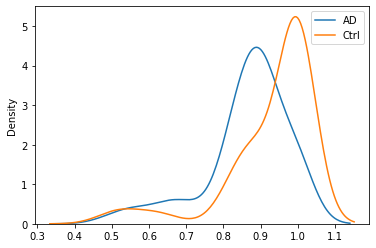

In [12]:
# Rm some Ctrl subs to make two grps balanced
TA1s_AD = load_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_AD_nofilter.pkl")
TA1s_Ctrl = load_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_Ctrl_nofilter.pkl")
TA1s_AD = TA1s_AD[kpAD==1]
TA1s_Ctrl = TA1s_Ctrl[kpCtrl==1]

gTA1s_Ctrl = TA1s_Ctrl.mean(axis=1);
gTA1s_AD = TA1s_AD.mean(axis=1);

if not RUN_PYTHON_SCRIPT:
    sns.kdeplot(gTA1s_AD, label="AD")
    sns.kdeplot(gTA1s_Ctrl, label="Ctrl")
    plt.legend()

### Get SA

In [15]:
# FC
AD_FCs = np.array([np.corrcoef(ts) for ts in AD_after_ts]);
Ctrl_FCs = np.array([np.corrcoef(ts) for ts in Ctrl_after_ts]);

In [16]:
dist_info = pd.read_csv(dataDir/"../OtherFils/DK68_spatial_info.csv");
locs_arr = np.array(dist_info[["x.mni", "y.mni", "z.mni"]]);

# transform the format
tmp = np.array(dist_info["name.full"]);
tmp[0] = "L Bankssts"
tmp[34] = "R Bankssts"

dist_order = []
for tm in tmp:
    tm_split = tm.split(" ")
    tm_split = [ix for ix in tm_split if ix not in ["gyrus", "lobule", "cortex"]]
    p1 = tm_split[0] + "-"
    p2 = "".join(tm_split[1:])
    dist_order.append(p1+p2.capitalize())
dist_order_dict = {
    v:i for i, v in enumerate(dist_order)
}

# the idxs to make dist_order[resort_idxs] = region_names
resort_idxs = [dist_order_dict[v] for v in region_names]
print(np.array_equal(np.array(dist_order)[resort_idxs], region_names))

locs_arr_FC = locs_arr[resort_idxs];

dist_mat = np.sqrt(np.sum(np.abs(locs_arr_FC[np.newaxis] - locs_arr_FC[:, np.newaxis])**2, axis=-1));


True


In [17]:
ui = np.triu_indices(68, 1)
dist_vec = dist_mat[ui];
AD_FC_vecs = np.array([AD_FC[ui] for AD_FC in AD_FCs])
Ctrl_FC_vecs = np.array([Ctrl_FC[ui] for Ctrl_FC in Ctrl_FCs]);

In [18]:
# the fn to bin the data
bins = np.arange(np.min(dist_vec),  np.max(dist_vec), 5)
bin_idxs = np.digitize(dist_vec, bins);

def _reg_yx(vec, bins=bins, bin_idxs=bin_idxs):
    yv = []
    xv = []
    for i in np.sort(list(set(bin_idxs))):
        xv.append(bins[i-1])
        yv.append(vec[bin_idxs==i].mean())
    return np.array(xv), np.array(yv)

In [19]:
# optimization
from scipy.optimize import minimize
# opt fn 
def _obj_f(x, data):
    """min obj_f
    """
    xv, yv = data
    sa_inf, sa_lam = x 
    left = (yv-sa_inf)/(1-sa_inf)
    right = np.exp(-xv/sa_lam)
    return np.sum((left-right)**2)
    
# initial value and bds
# (sa_inf, sa_lam)
x0s = ([-0.5, 25], [0, 50], [0.5, 75])
eps = 1e-5
bounds = [(-1+eps, 1-eps), (0+eps, 100)]

[(-0.99999, 0.99999), (1e-05, 100)]

In [20]:
def _minimize(fun, x0s, bounds, args):
    """A simple wrapper of minimize to allow multiple initial pts
    """
    fn_v = []
    xs = []
    for x0 in x0s:
        res = minimize(fun, x0, bounds=bounds, args=args)
        xs.append(res.x)
        fn_v.append(res.fun)
    return xs[np.argmin(fn_v)]

In [21]:
SAs = []
for vec in tqdm(AD_FC_vecs):
    xv, yv = _reg_yx(vec);
    res = _minimize(_obj_f, x0s, bounds=bounds, args=([xv, yv], ))
    SAs.append(res)
SAs_AD = np.array(SAs);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 70.19it/s]


In [22]:
SAs = []
for vec in tqdm(Ctrl_FC_vecs):
    xv, yv = _reg_yx(vec);
    res = _minimize(_obj_f, x0s, bounds=bounds, args=([xv, yv], ))
    SAs.append(res)
SAs_Ctrl = np.array(SAs);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 73.08it/s]


In [60]:
save_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_AD_nofilter.pkl", SAs_AD)
save_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_Ctrl_nofilter.pkl", SAs_Ctrl)

Save to ../../results/neuroimage_r1/SA_TA_features/SA_AD_filter.pkl
Save to ../../results/neuroimage_r1/SA_TA_features/SA_Ctrl_filter.pkl


In [13]:
SAs_AD = load_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_AD_nofilter.pkl")
SAs_Ctrl = load_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_Ctrl_nofilter.pkl");

# Rm some Ctrl subs to make two grps balanced
SAs_AD = SAs_AD[kpAD==1]
SAs_Ctrl = SAs_Ctrl[kpCtrl==1];

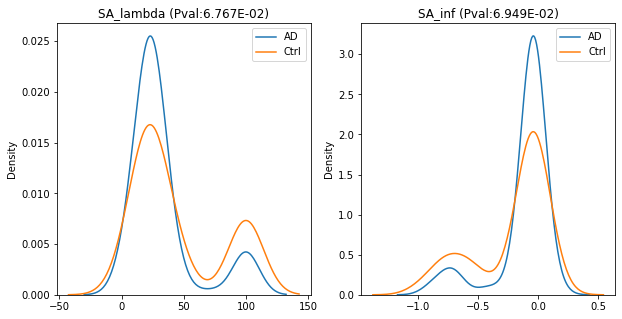

In [14]:
plt.figure(figsize=[10, 5])

AD_vec = SAs_AD[:, 1]
Ctrl_vec = SAs_Ctrl[:, 1]
pval = scipy.stats.mannwhitneyu(AD_vec, Ctrl_vec).pvalue

plt.subplot(121)
plt.title(f"SA_lambda (Pval:{pval:.3E})")
sns.kdeplot(AD_vec, label="AD")
sns.kdeplot(Ctrl_vec, label="Ctrl")
plt.legend()

AD_vec = SAs_AD[:, 0]
Ctrl_vec = SAs_Ctrl[:, 0]
pval = scipy.stats.mannwhitneyu(AD_vec, Ctrl_vec).pvalue

plt.subplot(122)
plt.title(f"SA_inf (Pval:{pval:.3E})")
sns.kdeplot(AD_vec, label="AD")
sns.kdeplot(Ctrl_vec, label="Ctrl")
plt.legend()

In [15]:
AD_vec = SAs_AD[:, 1]
Ctrl_vec = SAs_Ctrl[:, 1]
v1 = np.concatenate([AD_vec, Ctrl_vec]);
v2 = np.array([1]*len(AD_vec)+[0]*len(Ctrl_vec))
scipy.stats.pearsonr(v1, v2)

(-0.1876474923500606, 0.012635509678335809)

## Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.cbook as cbook
from scipy.stats import  norm
import statsmodels.api as sm

from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict
from tmp_utils import get_ABIC

import warnings
warnings.filterwarnings('ignore')

def TuningCFn(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6], penalty="l2"):
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(inpX):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(inpX[trIdxs, :], inpY[trIdxs])
            eProbs.append(clf.predict_proba(inpX[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(inpY, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(inpY, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
            
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res


### Get data

In [48]:
TA1s_AD = load_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_AD_nofilter.pkl")
TA1s_Ctrl = load_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_Ctrl_nofilter.pkl")

SAs_AD = load_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_AD_nofilter.pkl")
SAs_Ctrl = load_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_Ctrl_nofilter.pkl");

TA1s_AD = TA1s_AD[kpAD==1]
TA1s_Ctrl = TA1s_Ctrl[kpCtrl==1]
gTA1s_Ctrl = TA1s_Ctrl.mean(axis=1);
gTA1s_AD = TA1s_AD.mean(axis=1);
SAs_AD = SAs_AD[kpAD==1]
SAs_Ctrl = SAs_Ctrl[kpCtrl==1];


In [58]:
TA_test = scipy.stats.ttest_ind(gTA1s_AD, gTA1s_Ctrl, equal_var=False)
SA_inf_test = scipy.stats.ttest_ind(SAs_AD[:, 0], SAs_Ctrl[:, 0], equal_var=False)
SA_lam_test = scipy.stats.ttest_ind(SAs_AD[:, 1], SAs_Ctrl[:, 1], equal_var=False);
print(f"Pvals: gTA:{TA_test.pvalue:.3E}; SA_lam:{SA_lam_test.pvalue:.3E}; SA_inf :{SA_inf_test.pvalue:.3E} ")

Pvals: gTA:5.119E-04; SA_lam:1.270E-02; SA_inf :2.405E-02 


In [17]:
SAs = SAs_AD
TA1s = TA1s_AD
gTA1s = gTA1s_AD

fs_all = []
for sub_ix in range(len(gTA1s)):
    fs = edict()
    
    #SA
    fs["SA_lam"] = SAs[sub_ix, 1]
    fs["SA_inf"] = SAs[sub_ix, 0]
    
    # TA
    fs["gTA"] = gTA1s[sub_ix]
    fs["TA"] = TA1s[sub_ix]

    fs_all.append(fs)

fs_AD = fs_all;

In [18]:
SAs = SAs_Ctrl
TA1s = TA1s_Ctrl
gTA1s = gTA1s_Ctrl

fs_all = []
for sub_ix in range(len(gTA1s)):
    fs = edict()
    
    #SA
    fs["SA_lam"] = SAs[sub_ix, 1]
    fs["SA_inf"] = SAs[sub_ix, 0]
    
    # TA
    fs["gTA"] = gTA1s[sub_ix]
    fs["TA"] = TA1s[sub_ix]

    fs_all.append(fs)

fs_Ctrl = fs_all;

In [19]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fs_AD)), np.zeros(len(fs_Ctrl))])
fsName = ["SA_lam", "SA_inf", "TA"]

XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fs_AD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fs_AD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fs_Ctrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fs_AD])
        cfCtrl = np.array([fs[fName] for fs in fs_Ctrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"
Cs = [0.05, 0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2]
print(preFix)

SA_lam_SA_inf_TA_l2


### First fit

In [20]:
# The opTuningC will be used throughout
goptC = TuningCFn(stdXs, Ys, Cs, penalty=penalty)["optC"]
print(goptC)

0.05


In [21]:
# fit the first reg
clf_final = LogisticRegression(penalty=penalty, random_state=0, C=goptC)
clf_final.fit(stdXs, Ys)
coefs_final = clf_final.coef_.reshape(-1);

In [22]:
# bootstrap
def _run_fn_boot(i):
    np.random.seed(i)
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    cur_optC = goptC
    #cur_optC = TuningCFn(stdXsBoot, YsBoot, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=cur_optC)
    clf.fit(stdXsBoot, YsBoot)
    paras_boot = clf.coef_.reshape(-1)
    return paras_boot
    
n_rep = 10000
with Parallel(n_jobs=20) as parallel:
    parass_boot = parallel(delayed(_run_fn_boot)(i) 
                   for i in tqdm(range(n_rep)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 596.19it/s]


In [24]:
parass_boot = np.array(parass_boot)
lows, ups = coefs_final-parass_boot.std(axis=0)*1.96, coefs_final+parass_boot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([fsName[:-1],
                         region_names])
select_fs_idx = kpidxBoot
print(kpidxIdBoot)

[ 0  4  6 10 17 19 30 35 51 54 58 61 63]


In [25]:
# Pvalue
test_stats_boot = coefs_final/parass_boot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(test_stats_boot)));

In [26]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefs_final[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": bootPvs[kpidxBoot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
resDF = pd.DataFrame(resDic)
print(resDF)

                   Feature  Parameters      Lower      Upper   Pvalues
0                   SA_lam  -1.957e-01 -3.386e-01 -5.281e-02 7.264e-03
1    L-Caudalmiddlefrontal  -1.794e-01 -3.020e-01 -5.676e-02 4.140e-03
2             L-Entorhinal  -1.495e-01 -2.631e-01 -3.579e-02 9.963e-03
3       L-Inferiortemporal  -1.802e-01 -3.009e-01 -5.945e-02 3.441e-03
4         L-Middletemporal  -1.710e-01 -3.076e-01 -3.450e-02 1.408e-02
5        L-Parahippocampal  -2.080e-01 -3.274e-01 -8.852e-02 6.441e-04
6        L-Superiorfrontal   1.565e-01  4.467e-02  2.683e-01 6.089e-03
7     L-Transversetemporal  -1.277e-01 -2.531e-01 -2.346e-03 4.586e-02
8         R-Middletemporal   1.402e-01  2.016e-02  2.602e-01 2.207e-02
9        R-Parsopercularis  -1.593e-01 -2.919e-01 -2.670e-02 1.854e-02
10           R-Postcentral   1.373e-01  1.576e-03  2.731e-01 4.740e-02
11             R-Precuneus   1.340e-01  2.697e-02  2.410e-01 1.413e-02
12  R-Rostralmiddlefrontal   1.669e-01  4.089e-02  2.929e-01 9.431e-03


### Second fit

In [27]:
# select fs
stdXs_selected = stdXs[:, select_fs_idx]
print(stdXs_selected.shape)

goptC2 = TuningCFn(stdXs_selected, Ys, Cs, penalty=penalty)["optC"]
print(goptC2)
def pred_run_fn_sel(trIdxs, testIdxs, curOptC=None):
    """
    This function trains a logistic regression model on the given training indices and predicts probabilities for the test indices.

    Args:
    trIdxs (array-like): Indices of the training data.
    testIdxs (array-like): Indices of the test data.

    Returns:
    eprob (array-like): Predicted probabilities for the test data.
    paras (array-like): Coefficients of the logistic regression model.
    """
    curStdXs, curYs = stdXs_selected[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    paras = clf.coef_.reshape(-1)
    eprob = clf.predict_proba(stdXs_selected[testIdxs, :])

    return eprob, paras, curOptC

(176, 13)
0.4


In [43]:
def get_ABIC(Xs, Ys, C):
    lam = 2/C
    clf_info = LogisticRegression(penalty="l2", random_state=0, C=C);
    clf_info.fit(Xs, Ys)
    eprobs1 = clf_info.predict_proba(Xs)[:, 1];
    logL = np.sum(Ys*np.log(eprobs1) + (1-Ys)*np.log(1-eprobs1));
    
    # effective df
    fXs = np.concatenate([np.ones((Xs.shape[0], 1)), Xs], axis=-1)
    logL_der2 = -fXs.T @ np.diag(eprobs1*(1-eprobs1)) @ fXs;
    logL_der2_ridge = logL_der2 - lam * np.eye(logL_der2.shape[0]);
    dfe = np.diag(logL_der2@np.linalg.inv(logL_der2_ridge)).sum();
    aic = -2*logL + 2*dfe
    bic = -2*logL + np.log(Ys.shape[0])*dfe
    return aic, bic
# get AIC and BIC 
get_ABIC(stdXs_selected, Ys, goptC2)

(198.64839126750022, 221.44218646769625)

In [ ]:
loo = LeaveOneOut()
with Parallel(n_jobs=20) as parallel:
    res = parallel(delayed(pred_run_fn_sel)(trIdxs, testIdxs) 
                   for trIdxs, testIdxs in tqdm(loo.split(stdXs_selected), total=len(stdXs_selected))
                  )
parass = np.array([ix[1] for ix in res])
eprobs = np.array([ix[0] for ix in res]).squeeze();
loo_auc = roc_auc_score(Ys, eprobs[:, 1])
loo_fpr, loo_tpr, loo_thresholds = roc_curve(Ys, eprobs[:, 1], pos_label=1)
print(loo_auc)

resROC = {"fpr":loo_fpr, "tpr":loo_tpr, "AUC":loo_auc}
save_pkl(resDir/f"TASA_ROCcurve_reg2.pkl", resROC)

In [32]:
def pred_run_fn_CV(i, curOptC=None):
    
    np.random.seed(i)
    nobs = stdXs_selected.shape[0]
    
    testIdxs = np.random.choice(nobs, int(nobs/5), False)
    trIdxs = np.delete(np.arange(nobs), testIdxs)
    
    curStdXs, curYs = stdXs_selected[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    eprob = clf.predict_proba(stdXs_selected[testIdxs, :])
    cur_auc = roc_auc_score(Ys[testIdxs], eprob[:, 1])
    return cur_auc, curOptC

n_rep = 10000
with Parallel(n_jobs=20) as parallel:
    res = parallel(delayed(pred_run_fn_CV)(i, goptC2) 
                   for i in tqdm(range(n_rep)))

aucs = [ix[0] for ix in res]
auc_m = np.mean(aucs)
auc_std = np.std(aucs)
print(f"The mean of AUC under 1000 repetitions is {auc_m:.3f} and the standard deviation is {auc_std:.3f}, "
      f"the 95% CI is ({np.quantile(aucs, 0.025):.3f}, {np.quantile(aucs, 0.975):.3f}).")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1008.67it/s]


The mean of AUC under 1000 repetitions is 0.788 and the standard deviation is 0.071, the 95% CI is (0.639, 0.918).
